<a href="https://colab.research.google.com/github/Madhumasa84/BitCamp2023_Cyber_masa/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install required packages (run once)
!pip install -q scikit-learn pandas matplotlib seaborn joblib


In [ ]:
#@title Check CSV presence and show head
import os
CSV_PATH = "/content/synth_emotion_dataset.csv"

print("Exists?", os.path.exists(CSV_PATH))
if os.path.exists(CSV_PATH):
    import pandas as pd
    df = pd.read_csv(CSV_PATH)
    print("Shape:", df.shape)
    display(df.head(8))
else:
    raise FileNotFoundError(f"{CSV_PATH} not found. Please upload the CSV to /content or change CSV_PATH.")


Exists? True
Shape: (300, 12)


,eeg_alpha,eeg_beta,eeg_theta,gsr,hr,temp,resp_rate,blink_rate,face_act,motion,valence_cont,valence_bin
0,7.088150,3.277527,4.578931,1.102840,80.693994,37.090111,15.293228,10,0.182120,0.218639,6.483076,High
1,10.282347,4.354473,6.560661,3.532299,64.222745,36.768203,17.980635,18,0.000000,0.000000,6.191458,High
2,3.867093,4.652889,2.209297,0.977175,60.350445,36.708399,19.680528,12,0.316524,0.177222,6.946562,High
3,5.481946,2.508620,1.244254,1.669545,77.799609,36.429745,14.228000,8,0.043878,0.308582,6.005686,High
4,7.061605,3.726725,3.427875,1.109053,68.508196,36.733407,16.105430,17,0.342391,0.114726,7.334046,High
5,19.416903,3.070230,5.485231,1.373985,56.972431,36.529312,17.867633,6,0.000000,0.092478,7.526957,High
6,13.834544,7.582598,2.392606,2.302733,59.937062,36.729116,11.304985,9,0.336049,0.387586,6.997367,High
7,6.730726,3.876964,3.004875,3.777801,72.220381,36.625893,14.615092,17,0.277311,0.434425,4.551352,Low


In [ ]:
#@title Pipeline code (run this cell)
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.inspection import permutation_importance
import joblib

# ---- config ----
RANDOM_STATE = 2025
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

def ensure_dirs(out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)

def load_data(csv_path: Path):
    print(f"Loading CSV from: {csv_path}")
    df = pd.read_csv(csv_path)
    print(f"Shape: {df.shape}")
    return df

def basic_eda(df: pd.DataFrame, out_dir: Path):
    preview_path = out_dir / "preview_first20rows.csv"
    df.head(20).to_csv(preview_path, index=False)
    print(f"Saved preview to {preview_path}")

    if "valence_cont" in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df["valence_cont"].dropna(), bins=18, kde=False)
        plt.title("Valence (continuous) - synthetic dataset")
        plt.xlabel("Valence (1..9)")
        plt.tight_layout()
        p = out_dir / "valence_cont_hist.png"
        plt.savefig(p)
        plt.close()
        print("Saved", p)

    if "valence_bin" in df.columns:
        plt.figure(figsize=(4,3.5))
        order = df['valence_bin'].value_counts().index.tolist()
        sns.countplot(x="valence_bin", data=df, order=order)
        plt.title("Valence (binary) balance")
        p = out_dir / "valence_bin_balance.png"
        plt.tight_layout()
        plt.savefig(p)
        plt.close()
        print("Saved", p)

    feature_preview = [c for c in ["eeg_alpha","eeg_beta","eeg_theta","gsr","hr","face_act"] if c in df.columns]
    if len(feature_preview) >= 2:
        pp = out_dir / "feature_pairs_preview.png"
        # sample if too large
        sample_df = df[feature_preview].dropna()
        if len(sample_df) > 300:
            sample_df = sample_df.sample(300, random_state=RANDOM_STATE)
        sns.pairplot(sample_df, corner=True)
        plt.suptitle("Feature pairs preview", y=1.02)
        plt.savefig(pp, dpi=150)
        plt.close()
        print("Saved", pp)

def build_and_run_pipeline(csv_path, out_dir, feature_cols):
    df = load_data(csv_path)
    ensure_dirs(out_dir)

    basic_eda(df, out_dir)

    if "valence_bin" not in df.columns:
        raise RuntimeError("Column 'valence_bin' not found in CSV")

    df = df[df['valence_bin'].notna()].copy()

    y = df['valence_bin'].astype(str)
    if set(y.unique()) - {"High","Low"}:
        print("Unique labels:", y.unique())
        print("Warning: labels are not exactly 'High'/'Low'. Proceeding with existing labels.")
    y = pd.Categorical(y, categories=sorted(y.unique()))

    features = [c for c in feature_cols if c in df.columns]
    if len(features) == 0:
        raise RuntimeError("None of the requested feature columns are present in the CSV. Available columns:\n" + ", ".join(df.columns))

    X = df[features].copy()
    data = pd.concat([X, pd.Series(y, name="valence_bin")], axis=1).dropna()
    X = data[features].astype(float)
    y = data['valence_bin'].astype(str)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
    )
    print("Train rows:", X_train.shape[0], "Test rows:", X_test.shape[0])

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
    ])

    param_grid = {
        "svm__C": [0.1, 1, 10, 50],
        "svm__gamma": ["scale", 0.01, 0.001, 0.0001]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1, return_train_score=False)
    grid.fit(X_train, y_train)

    print("Best params:", grid.best_params_)
    print("Best CV ROC AUC:", grid.best_score_)

    model_path = out_dir / "svm_valence_model.joblib"
    joblib.dump(grid, model_path)
    print("Saved model to", model_path)

    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
    cm_df = pd.DataFrame(cm, index=grid.classes_, columns=grid.classes_)
    cm_file = out_dir / "svm_confusionmatrix_test.csv"
    cm_df.to_csv(cm_file)
    print("Saved confusion matrix to", cm_file)
    print("Classification report:\n", classification_report(y_test, y_pred))

    test_out = X_test.copy()
    test_out['true'] = y_test.values
    test_out['predicted'] = y_pred

    prob_col_name = "High" if "High" in grid.classes_ else (grid.classes_[1] if len(grid.classes_)>1 else grid.classes_[0])
    class_index = list(grid.classes_).index(prob_col_name)
    test_out['prob_' + str(prob_col_name)] = y_prob[:, class_index]
    pred_csv = out_dir / "svm_test_predictions.csv"
    test_out.to_csv(pred_csv, index=False)
    print("Saved test predictions to", pred_csv)

    try:
        y_test_binary = (y_test == prob_col_name).astype(int)
        fpr, tpr, _ = roc_curve(y_test_binary, y_prob[:, class_index])
        auc_val = auc(fpr, tpr)
        print("Test AUC:", round(auc_val, 4))
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_val:.3f})")
        plt.plot([0,1], [0,1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("SVM ROC (test)")
        plt.legend(loc="lower right")
        roc_png = out_dir / "svm_test_roc.png"
        plt.tight_layout()
        plt.savefig(roc_png)
        plt.close()
        print("Saved ROC plot to", roc_png)
    except Exception as e:
        print("Could not compute ROC:", e)

    print("Computing permutation importance (may take some time)...")
    result = permutation_importance(grid.best_estimator_, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1, scoring="roc_auc")
    perm_df = pd.DataFrame({
        "feature": features,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)
    perm_csv = out_dir / "feature_importance_perm.csv"
    perm_df.to_csv(perm_csv, index=False)
    print("Saved permutation importance to", perm_csv)

    plt.figure(figsize=(7,5))
    sns.barplot(x="importance_mean", y="feature", data=perm_df)
    plt.xlabel("Mean decrease in score (permutation importance)")
    plt.title("Permutation importance (SVM pipeline)")
    p_perm = out_dir / "feature_importance_perm.png"
    plt.tight_layout()
    plt.savefig(p_perm)
    plt.close()
    print("Saved", p_perm)

    print("Training RandomForest for feature importance check...")
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    rf.fit(X_train, y_train)
    rf_imp = pd.DataFrame({
        "feature": features,
        "importance": rf.feature_importances_
    }).sort_values("importance", ascending=False)
    rf_csv = out_dir / "rf_feature_importance.csv"
    rf_imp.to_csv(rf_csv, index=False)
    print("Saved RF importance to", rf_csv)

    plt.figure(figsize=(7,5))
    sns.barplot(x="importance", y="feature", data=rf_imp)
    plt.title("Random Forest feature importance")
    p_rf = out_dir / "feature_importance_rf.png"
    plt.tight_layout()
    plt.savefig(p_rf)
    plt.close()
    print("Saved", p_rf)

    summary_txt = out_dir / "svm_model_summary.txt"
    with open(summary_txt, "w") as f:
        f.write(f"Best params: {grid.best_params_}\n")
        f.write(f"Best CV ROC AUC: {grid.best_score_}\n")
        f.write("\nClassification report (test):\n")
        f.write(classification_report(y_test, y_pred))
    print("Saved model summary to", summary_txt)

    print("\nFiles in:", out_dir)
    for fn in [
        "svm_valence_model.joblib",
        "svm_confusionmatrix_test.csv",
        "svm_test_predictions.csv",
        "svm_test_roc.png",
        "feature_importance_perm.csv",
        "feature_importance_perm.png",
        "rf_feature_importance.csv",
        "feature_importance_rf.png",
        "svm_model_summary.txt"
    ]:
        print("-", fn)


Loaded CSV: synth_emotion_dataset.csv  Shape: (300, 12)
Train rows: 225, Test rows: 75
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Params: {'svm__C': 1, 'svm__gamma': 0.001}
Best CV ROC AUC: 0.9038660841292421

Confusion Matrix:
       High  Low
High    63    0
Low     12    0


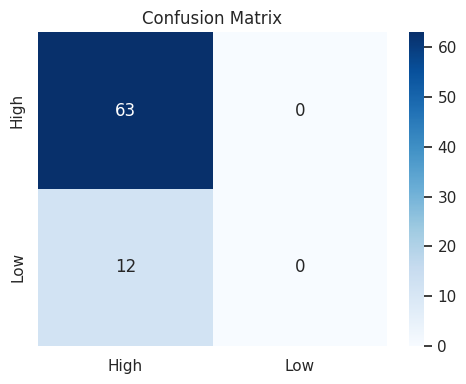

Test AUC: 0.946


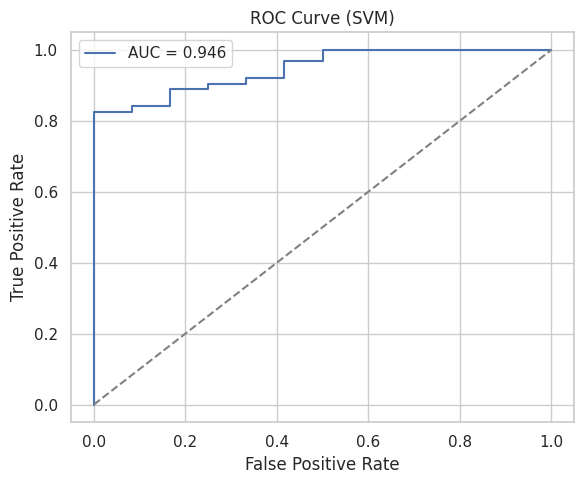


Calculating permutation importance...


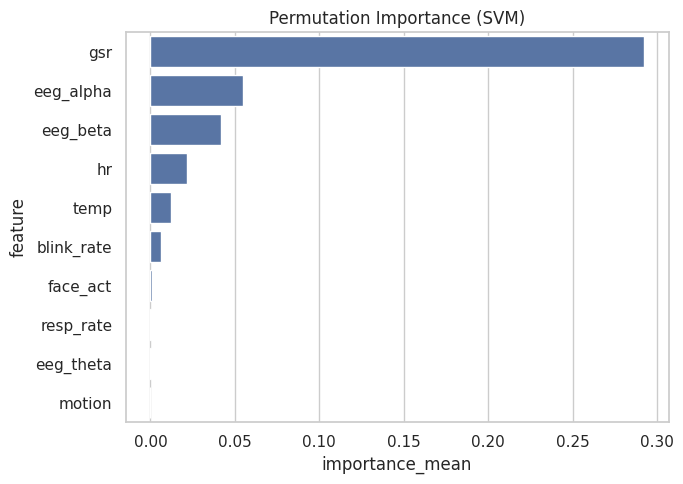

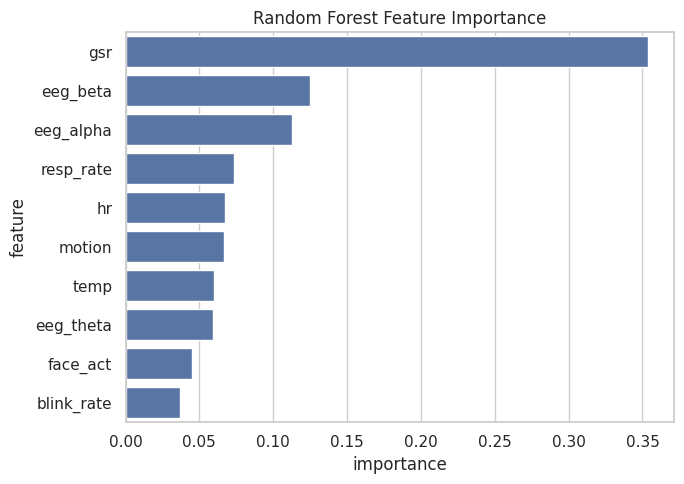


All results saved in: /content/synth_outputs


In [ ]:
import os
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance
import joblib

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

RANDOM_STATE = 2025

# ---------- CONFIGURE THESE ----------
CSV_PATH = "synth_emotion_dataset.csv"  # your dataset filename (same folder)
OUTDIR = Path("synth_outputs")           # results folder
# -------------------------------------

OUTDIR.mkdir(exist_ok=True)

# Load dataset
df = pd.read_csv(CSV_PATH)
print(f"Loaded CSV: {CSV_PATH}  Shape: {df.shape}")

if "valence_bin" not in df.columns:
    raise ValueError("The dataset must contain a 'valence_bin' column for binary labels ('High'/'Low').")

feature_cols = ["eeg_alpha","eeg_beta","eeg_theta","gsr","hr","temp",
                "resp_rate","blink_rate","face_act","motion"]

features = [c for c in feature_cols if c in df.columns]
if not features:
    raise ValueError(f"No matching features found in CSV. Available: {df.columns.tolist()}")

df = df.dropna(subset=features + ["valence_bin"])
X = df[features].astype(float)
y = df["valence_bin"].astype(str)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=RANDOM_STATE
)
print(f"Train rows: {len(X_train)}, Test rows: {len(X_test)}")

# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
])

param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__gamma": ["scale", 0.01, 0.001]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("\nBest Params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

# Save model
joblib.dump(grid, OUTDIR / "svm_valence_model.joblib")

# Predictions
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)
pos_class = "High" if "High" in grid.classes_ else grid.classes_[1]
pos_idx = list(grid.classes_).index(pos_class)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=grid.classes_)
cm_df = pd.DataFrame(cm, index=grid.classes_, columns=grid.classes_)
cm_df.to_csv(OUTDIR / "confusion_matrix.csv")
print("\nConfusion Matrix:\n", cm_df)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(OUTDIR / "confusion_matrix.png")
plt.show()

# ROC Curve
y_test_bin = (y_test == pos_class).astype(int)
fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, pos_idx])
auc_val = auc(fpr, tpr)
print(f"Test AUC: {auc_val:.3f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM)")
plt.legend()
plt.tight_layout()
plt.savefig(OUTDIR / "roc_curve.png")
plt.show()

# Permutation Importance
print("\nCalculating permutation importance...")
perm = permutation_importance(grid.best_estimator_, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
perm_df = pd.DataFrame({
    "feature": features,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)
perm_df.to_csv(OUTDIR / "permutation_importance.csv", index=False)

plt.figure(figsize=(7,5))
sns.barplot(x="importance_mean", y="feature", data=perm_df)
plt.title("Permutation Importance (SVM)")
plt.tight_layout()
plt.savefig(OUTDIR / "permutation_importance.png")
plt.show()

# Random Forest Importance
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
rf_imp = pd.DataFrame({
    "feature": features,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)
rf_imp.to_csv(OUTDIR / "rf_importance.csv", index=False)

plt.figure(figsize=(7,5))
sns.barplot(x="importance", y="feature", data=rf_imp)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig(OUTDIR / "rf_importance.png")
plt.show()

# Save Summary
with open(OUTDIR / "model_summary.txt", "w") as f:
    f.write(f"Best Params: {grid.best_params_}\n")
    f.write(f"Best CV ROC AUC: {grid.best_score_:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred))

print(f"\nAll results saved in: {OUTDIR.resolve()}")

